# Preprocessing Images for OCR for AutoReg

## Topics that would be covered for recognizing devanagari license plates and for preprocessing them

1. Inverting the image
2. Rescaling
3. Binarization
4. Noise Removal
5. Dilation and Erosion
6. Rotation / Deskewing
7. Removing borders
8. Missing borders
9. Transparency / Alpha Channel

In [10]:
import cv2
from matplotlib import pyplot as plt
image_file = "image/plate.png"
img = cv2.imread(image_file)

In [11]:
# https://stackoverflow.com/questions/28816046

import matplotlib.pyplot as plt
import numpy as np

def display(im_path):
    im_data = plt.imread(im_path)
    if im_data.ndim == 2:  # Grayscale image
        im_data = np.dstack([im_data] * 3)  # Convert to RGB
    height, width, depth = im_data.shape if im_data.ndim == 3 else (*im_data.shape, 1)
    dpi = 80
    figsize = width / float(dpi), height / float(dpi)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im_data, cmap='gray' if im_data.shape[2] == 1 else None)
    plt.show()

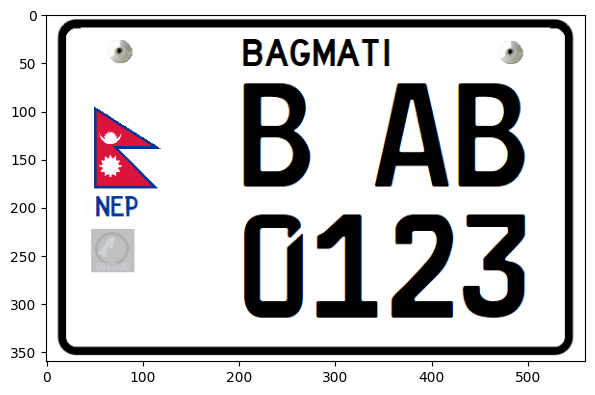

In [12]:
display(image_file)

# Inverting the image for easy recognition


In [13]:
inverted_image = cv2.bitwise_not(img)
cv2.imwrite("temp/inverted.jpg", inverted_image)

True

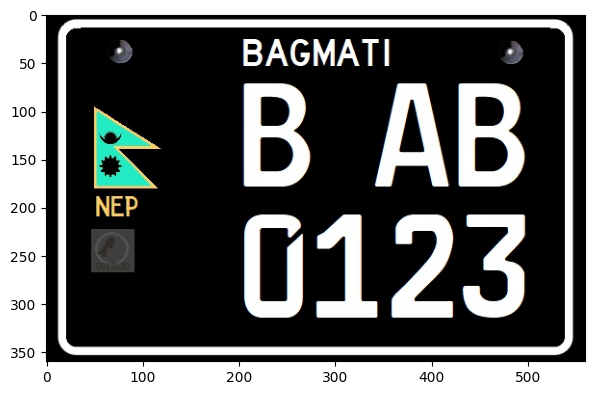

In [14]:
display("temp/inverted.jpg")

## Rescaling

Range to be determined (Height of the character and the DPI)

## Binarization

Changing the image into greyscale with a function

In [15]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [16]:
gray_image = grayscale(img)
cv2.imwrite("temp/gray.jpg", gray_image)

True

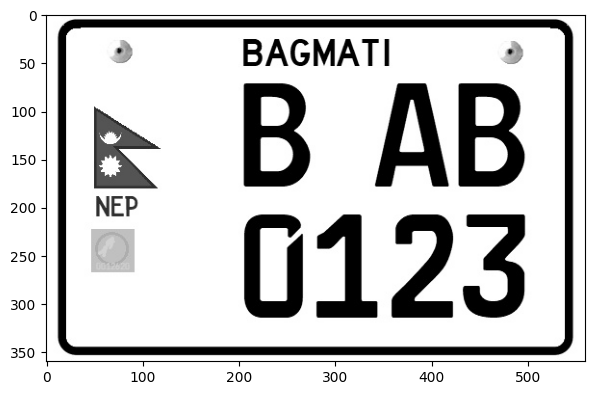

In [17]:
display("temp/gray.jpg")

## Converting it to strictly black and white using threshold

In [18]:
thresh, im_bw = cv2.threshold(gray_image, 200, 340, cv2.THRESH_BINARY)
cv2.imwrite("temp/bw_image.jpg", im_bw)

True

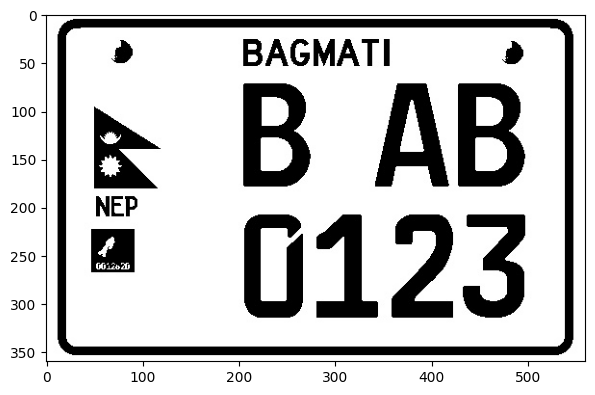

In [19]:
display("temp/bw_image.jpg")

# Noise Removal

In [20]:
def noise_removal(image):
    import numpy as np
    kernel = np.ones((1,1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1,1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)    

In [21]:
no_noise = noise_removal(im_bw)
cv2.imwrite("temp/no_noise.jpg", no_noise)

True

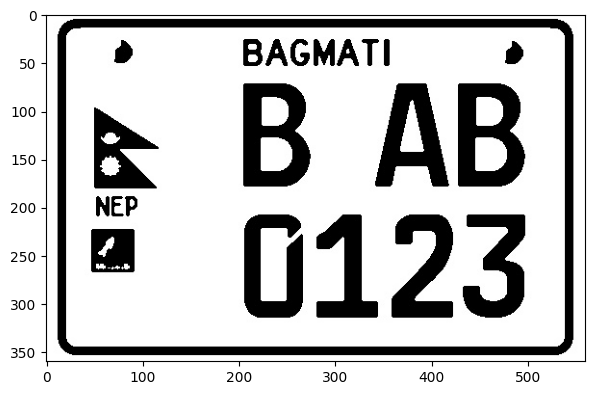

In [22]:
display("temp/no_noise.jpg")

## Dilation and Erosion

In [23]:
def thin_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((8,8), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

In [24]:
eroded_image = thin_font(no_noise)
cv2.imwrite("temp/eroded_image.jpg", eroded_image)

True

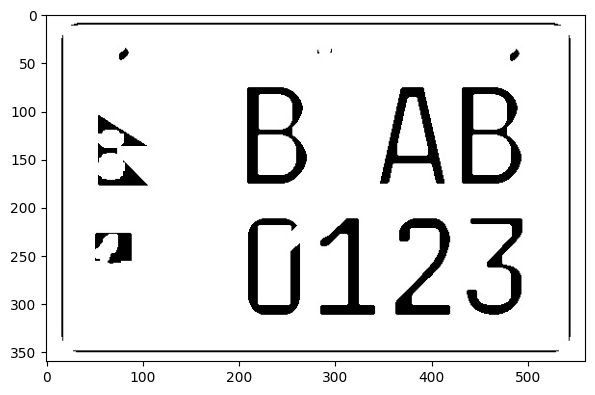

In [25]:
display("temp/eroded_image.jpg")

# Dilation

In [26]:
def thick_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

In [27]:
dilated_image = thick_font(no_noise)
cv2.imwrite("temp/dilated_image.jpg", dilated_image)

True

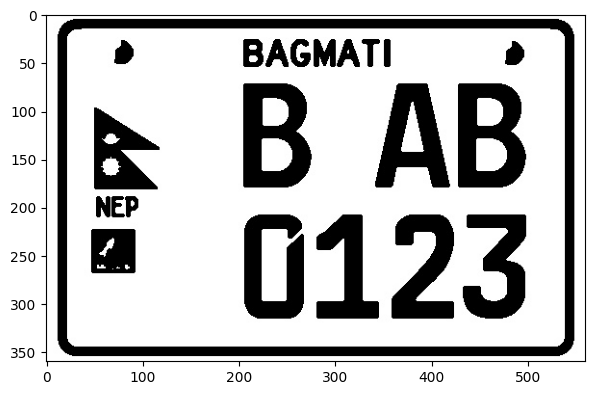

In [28]:
display("temp/dilated_image.jpg")

## Rotation / Deskewing

Source:
 `https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df`


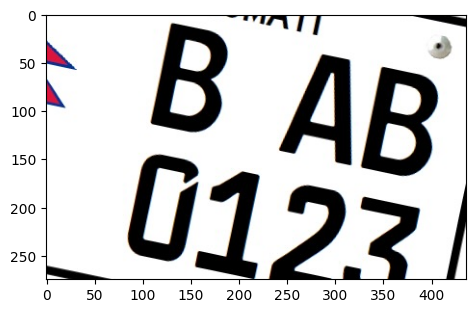

In [33]:
import cv2
import numpy as np
new = cv2.imread("image/rotatedslightly.jpeg")
display("image/rotatedslightly.jpeg")

In [46]:
# Calculate skew angle of an image
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -0.07 * angle)

In [47]:
fixed = deskew(new)
cv2.imwrite("temp/rotated_fixed.jpg", fixed)

True

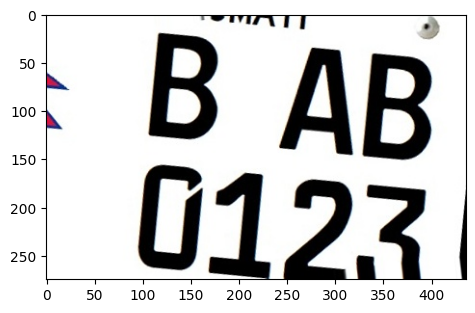

In [48]:
display("temp/rotated_fixed.jpg")

# Removing the borders of a license plate image

In [67]:
def remove_borders(image):
    contours, heirarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return crop

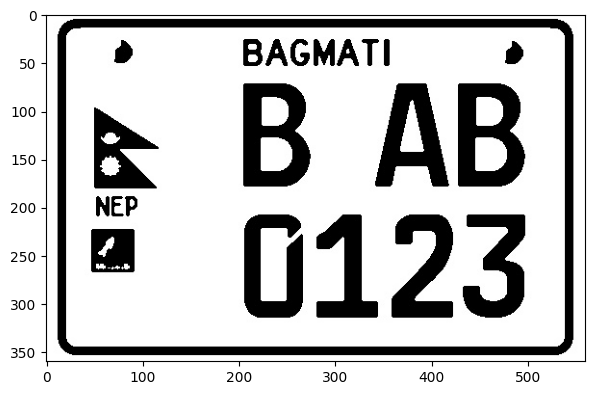

In [68]:
no_borders = remove_borders(no_noise)
cv2.imwrite("temp/no_borders.jpg", no_borders)
display("temp/no_borders.jpg")

## Missing Borders

In [69]:
color = [255,255,255]
top, bottom, left, right = [150]*4

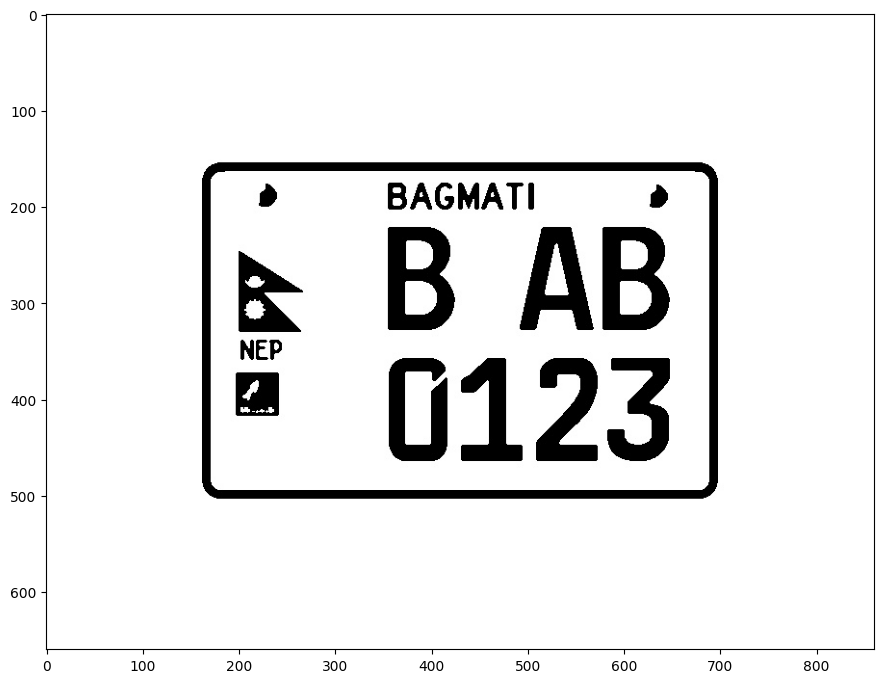

In [70]:
image_with_border = cv2.copyMakeBorder(no_borders, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
cv2.imwrite("temp/image_with_border.jpg", image_with_border)
display("temp/image_with_border.jpg")